Data source: ht<span></span>tps://www.kaggle.com/cityofLA/los-angeles-metro-bike-share-trip-data

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
df = pd.read_csv('input/metro-bike-share-trip-data.csv')

c:\python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Overall Information

In [3]:
df.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07T10:37:00,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07T12:51:00,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 16 columns):
Trip ID                       132427 non-null int64
Duration                      132427 non-null int64
Start Time                    132427 non-null object
End Time                      132427 non-null object
Starting Station ID           132408 non-null float64
Starting Station Latitude     132379 non-null float64
Starting Station Longitude    132379 non-null float64
Ending Station ID             132331 non-null float64
Ending Station Latitude       131376 non-null float64
Ending Station Longitude      131376 non-null float64
Bike ID                       132417 non-null float64
Plan Duration                 131661 non-null float64
Trip Route Category           132427 non-null object
Passholder Type               132427 non-null object
Starting Lat-Long             98622 non-null object
Ending Lat-Long               131376 non-null object
dtypes: float64(8), int64(2), object

Check whether dataframe has any null values

In [5]:
df.isnull().any().any()

True

Drop out rows with null values from the dataframe

In [6]:
df = df.dropna()

### Duration
Let's take a look at the Duration column

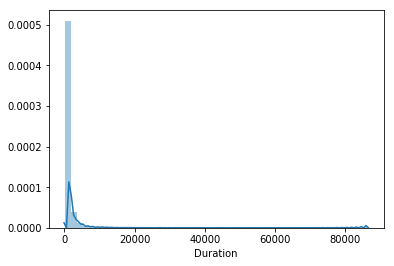

In [7]:
sns.distplot(df['Duration'])

In [8]:
def percentiles(column, percentiles):
    for percentile in percentiles:
        print('{0}th percentile = {1}'.format(percentile, np.percentile(column,percentile)))
        
percentiles(df['Duration'],[0,1,5,20,30,40,50,60,70,80,90,100])

0th percentile = 60.0
1th percentile = 120.0
5th percentile = 180.0
20th percentile = 360.0
30th percentile = 420.0
40th percentile = 540.0
50th percentile = 600.0
60th percentile = 780.0
70th percentile = 960.0
80th percentile = 1260.0
90th percentile = 1980.0
100th percentile = 86400.0


These is no explicit breakthrough in data distribution that could cleary testify that some values are outliers. Also there are no 0 values. It is resonable to normalize distribution of this column by a logarithm.

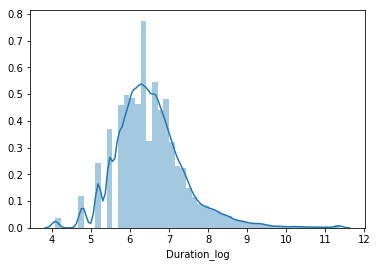

In [9]:
df['Duration_log'] = np.log(df['Duration'])
sns.distplot(df['Duration_log'])

In [10]:
print('Trip route categories: ',df['Trip Route Category'].unique())
print('Passholder Types: ',df['Passholder Type'].unique())

Trip route categories:  ['Round Trip' 'One Way']
Passholder Types:  ['Monthly Pass' 'Flex Pass' 'Walk-up']


The only provided identifier of Bike Share user is 'Passholder Type'

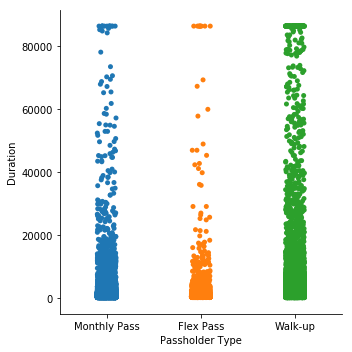

In [11]:
sns.catplot(x = 'Passholder Type', y = 'Duration', data = df)

### Distance
Database provides Starting and Ending stations longitudes and latitudes. For 'One Way' trip route we can calculate distance between two stations.

In [12]:
def distance_between_coordinates(lat1, lon1, lat2, lon2):
    earth_radius_km = 6371
    
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    
    a = math.sin(d_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return  earth_radius_km * c

In [13]:
df['Distance'] = df.apply(lambda x: distance_between_coordinates(x['Starting Station Latitude'],x['Starting Station Longitude'],x['Ending Station Latitude'],x['Ending Station Longitude']),axis = 1)